In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
top = mpl.colormaps['Reds_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
residual_cmp = ListedColormap(newcolors, name='RedsBlue')
from matplotlib.patches import Ellipse
import emcee
import corner
from radmc3dPy import image
import sys
sys.path.insert(0,'../../')
from X22_model.disk_model import *
from CB68.data_dict import data_dict
from radmc.setup import *
sys.path.insert(0,'../')
from fit_with_GIdisk.find_center import find_center
from astropy.coordinates import SkyCoord
import io
import contextlib

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.


In [2]:
reader = emcee.backends.HDFBackend("progress.h5")

## Chain step 

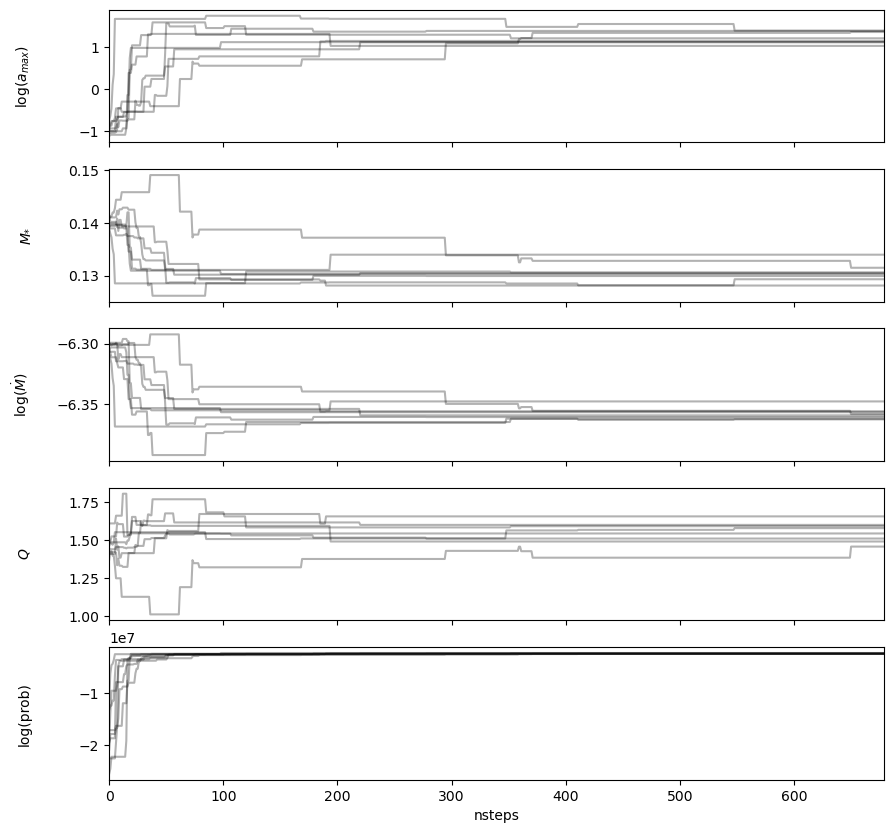

In [16]:
label = [r'log($a_{max}$)',r'$M_{*}$', r'log($\dot{M}$)', r"$Q$"]

fig, axes = plt.subplots(len(label)+1, figsize=(10, 10), sharex=True)
samples = reader.get_chain()
log_prob = reader.get_log_prob()

for i in range(len(label)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    # ax.set_xlim(0, len(samples))
    ax.set_ylabel(label[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].plot(log_prob, "k", alpha=0.3)
axes[-1].set_xlim(0, len(samples))
axes[-1].set_xlabel("nsteps")
axes[-1].set_ylabel("log(prob)")
axes[-1].yaxis.set_label_coords(-0.1, 0.5)

In [10]:
plt.savefig('chain_step.pdf', transparent = True)
plt.close()

## Posterior

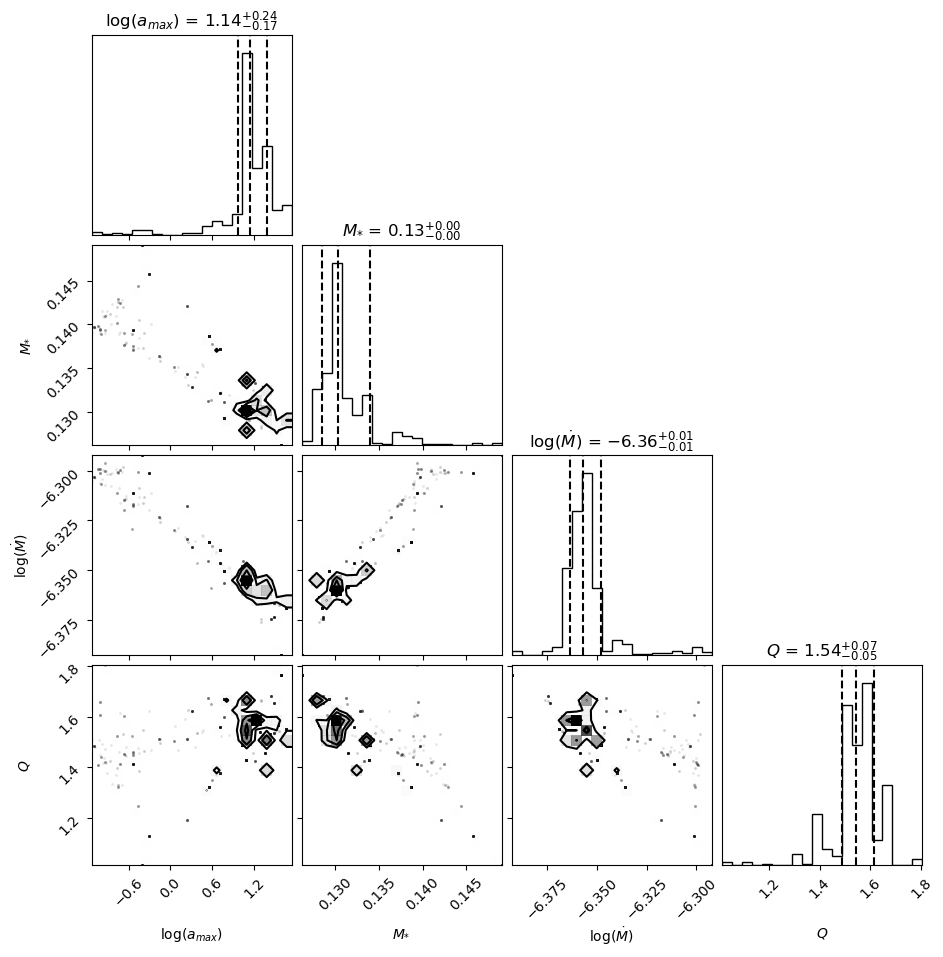

In [8]:
chains = reader.get_chain(discard=0, flat=False)
n_steps, n_walkers, n_params = chains.shape

acceptance_fractions = np.mean(
    np.diff(reader.get_log_prob(discard=0, flat=False), axis=0) != 0, axis=0
)

# Define a threshold for stuck walkers
threshold = 0.001
valid_walkers = np.where(acceptance_fractions > threshold)[0]

# Filter the chains to exclude stuck walkers
filtered_chains = chains[:, valid_walkers, :]

# Flatten the filtered chains
flat_samples = filtered_chains.reshape(-1, n_params)[::1]
fig = corner.corner(
    flat_samples[::], labels=label,
    show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])

In [11]:
fig.savefig('posterior.pdf', transparent=True)
plt.close()

## Best-fit model from parameters of highest probability

In [14]:
samples = reader.get_chain(discard=0, flat=True)
theta_max = samples[np.argmax(reader.get_log_prob(flat=True, discard=0))]

print(f"Maximum grain size: {10**theta_max[0]:.2e} mm")
print(f"Stellar mass: {theta_max[1]:.2e} Msun")
print(f"Accretion rate: {10**theta_max[2]:.2e} Msun/yr")
print(f"Toomre Q: {theta_max[3]:.2f}")

Maximum grain size: 1.30e+01 mm
Stellar mass: 1.30e-01 Msun
Accretion rate: 4.40e-07 Msun/yr
Toomre Q: 1.54


In [ ]:

a, mstar, mdot, Q = theta_max[0], theta_max[1], theta_max[2], theta_max[3]

fit_data    = [data_dict["1.3_edisk"], data_dict["3.2_faust"]]
lam_list    = [fit_data[0]["wav"], fit_data[1]["wav"]]
sigma_list  = [fit_data[0]["sigma"], fit_data[1]["sigma"]]

disk_posang = 45

desire_size = [50, 250]

observation_data = []
beam_pa = []
beam_axis = []
size_au = []
npix = []

for i, data in enumerate(fit_data):
    if i == 0:
        c = SkyCoord('16h57m19.64278s', '-16d09m24.0157s', frame='icrs')
    else:
        c = SkyCoord('16h57m19.64147s', '-16d09m23.9756s', frame='icrs')
    ra_deg = c.ra.deg
    dec_deg = c.dec.deg

    image_class = DiskImage(
        fname = data["fname"],
        ra_deg = ra_deg,
        dec_deg = dec_deg,
        distance_pc = 140,
        rms_Jy = data["sigma"], # convert to Jy/beam
        disk_pa = disk_posang,
        img_size_au = desire_size[i],
        remove_background=True
    )
    observation_data.append(image_class.img)
    beam_pa.append(image_class.beam_pa)
    beam_axis.append([image_class.beam_maj_au/image_class.distance_pc,
                      image_class.beam_min_au/image_class.distance_pc])
    size_au.append(image_class.img_size_au)
    npix.append(image_class.img.shape[0])

model = radmc3d_setup(silent=False)
model.get_mastercontrol(filename=None,
                        comment=None,
                        incl_dust=1,
                        incl_lines=1,
                        nphot=500000,
                        nphot_scat=200000,
                        scattering_mode_max=2,
                        istar_sphere=1,
                        num_cpu=2)
model.get_linecontrol(filename=None,
                    methanol='ch3oh leiden 0 0 0')
model.get_continuumlambda(filename=None,
                        comment=None,
                        lambda_micron=None,
                        append=False)
model.get_diskcontrol(  d_to_g_ratio = 0.01,
                        a_max=10**a, 
                        Mass_of_star=mstar, 
                        Accretion_rate=10**mdot,
                        Radius_of_disk=30,
                        Q=Q,
                        NR=200,
                        NTheta=200,
                        NPhi=10)
model.get_heatcontrol(heat='accretion')

model_image_list = []

for i, wav in enumerate(lam_list):
    os.system(f'radmc3d image npix {npix[i]} sizeau {size_au[i]} posang {-45} incl 73 lambda {wav*1000} noline > /dev/null 2>&1')
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        im = image.readImage()
    # im = image.readImage()
    # model_image = image.readImage()
    model_image = im.imConv(dpc=140, fwhm=beam_axis[i], pa=-beam_pa[i])
    pixel_area = (size_au[i]/npix[i]/140)**2
    beam_area = beam_axis[i][0]*beam_axis[i][1]*np.pi/(4*np.log(2))
    model_image_list.append(model_image.imageJyppix[:, :, 0]/(140**2)*(beam_area/pixel_area))
    


fig, ax = plt.subplots(2,3, sharex=False, sharey=False, figsize=(15,10))
fig.subplots_adjust(left=0.05, right=0.97, top=0.9, bottom=0.1, wspace=0.0, hspace=0.0)
v_max_list = [4, 7]
for i, data in enumerate(fit_data):

    mask = observation_data[i] < 10*sigma_list[i]
    observation_data[i][mask] = 0
    model_image_list[i][mask.T] = 0

    cb68 = ax[i, 0].imshow(observation_data[i]*1e3, cmap='jet', origin='lower', vmin=0, vmax=v_max_list[i])
    colorbar = fig.colorbar(cb68, ax=ax[i, 0], pad=0.00, aspect=30, shrink=.98)
    colorbar.set_label('Intensity (mJy/beam)')
    ax[i, 0].set_xlabel('AU', fontsize=14)
    ax[i, 0].set_xticks([0, observation_data[i].shape[0]//2, observation_data[i].shape[0]-1])
    ax[i, 0].set_xticklabels([-np.round(size_au[i]), 0, np.round(size_au[i])])
    ax[i, 0].set_yticks([0, observation_data[i].shape[0]//2, observation_data[i].shape[0]])
    ax[i, 0].set_yticklabels([-np.round(size_au[i]), 0, np.round(size_au[i])])
    ax[i, 0].set_ylabel('AU', fontsize=14)
    ax[i, 0].set_title('eDisk (1.3 mm)', fontsize=14)

    # beam = Ellipse((130, 10), width=DI_alma.beam_min_au/DI_alma.au_per_pix, height=DI_alma.beam_maj_au/DI_alma.au_per_pix,
    #             angle=DI_alma.beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
    # ax[i, 0].add_patch(beam)


    # ax[0].contour(DI_alma.img, levels=[50*40e-6]ors='black', linewidths=0.65)

    model = ax[i, 1].imshow(model_image_list[i].T*1e3, cmap='jet', origin='lower', vmin=0, vmax=v_max_list[i])
    colorbar = fig.colorbar(model, ax=ax[i, 1], pad=0.00, aspect=30, shrink=.98)
    colorbar.set_label('Intensity (mJy/beam)')
    # beam = Ellipse((120, 10), width=DI_alma.beam_min_au/DI_alma.au_per_pix, height=DI_alma.beam_maj_au/DI_alma.au_per_pix,
    #             angle=DI_alma.beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
    ax[i, 1].set_xticks([0, observation_data[i].shape[0]//2, observation_data[i].shape[0]-1])
    ax[i, 1].set_xticklabels([-np.round(size_au[i]), 0, np.round(size_au[i])])
    ax[i, 1].set_xlabel('AU', fontsize=14)
    ax[i, 1].set_yticks([])
    ax[i, 1].set_title('Best-fit GIdisk model', fontsize=14)

    # beam = Ellipse((130, 10), width=DI_alma.beam_min_au/DI_alma.au_per_pix, height=DI_alma.beam_maj_au/DI_alma.au_per_pix,
    #             angle=DI_alma.beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
    # ax[i, 1].add_patch(beam)

    residual = ax[i, 2].imshow((observation_data[i]-model_image_list[i].T)*1e3, cmap=residual_cmp, origin='lower',
                               vmin=-(v_max_list[i]//2), vmax=(v_max_list[i]//2))
    colorbar = fig.colorbar(residual, ax=ax[i, 2], pad=0.00, aspect=30, shrink=.98)
    colorbar.set_label('Intensity (mJy/beam)')
    ax[i, 2].set_xticks([0, observation_data[i].shape[0]//2, observation_data[i].shape[0]-1])
    ax[i, 2].set_xticklabels([-np.round(size_au[i]), 0, np.round(size_au[i])])
    ax[i, 2].set_xlabel('AU', fontsize=14)
    ax[i, 2].set_yticks([])
    ax[i, 2].set_title('Residual', fontsize=14)

    # beam = Ellipse((130, 10), width=DI_alma.beam_min_au/DI_alma.au_per_pix, height=DI_alma.beam_maj_au/DI_alma.au_per_pix,
    #             angle=DI_alma.beam_pa, edgecolor='k', facecolor='k', lw=1.5, fill=True)
    # ax[i, 2].add_patch(beam)


# plt.tight_layout()
# plt.show()
plt.savefig('residual_best.pdf', transparent=True)